<div class="alert alert-block alert-info">
<b>Deadline:</b> May 03, 2023 (Wednesday) 23:00
</div>

# Exercise 1. Bottleneck autoencoders

The goal of this exercise is to get familiar with bottleneck autoencoders.

In [1]:
skip_training = True  # Set this flag to True before validation and submission

In [2]:
# During evaluation, this cell sets skip_training to True
# skip_training = True

import tools, warnings
warnings.showwarning = tools.customwarn

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import tools
import tests

In [4]:
# When running on your own computer, you can specify the data directory by:
# data_dir = tools.select_data_dir('/your/local/data/directory')
data_dir = tools.select_data_dir()

The data directory is ../data


In [5]:
# Select the device for training (use GPU if you have one)
#device = torch.device('cuda:0')
device = torch.device('cpu')

In [6]:
if skip_training:
    # The models are always evaluated on CPU
    device = torch.device("cpu")

# Data

In this exercise, we use the standard MNIST data.

In [7]:
transform = transforms.Compose([
    transforms.ToTensor(),  # Transform to tensor
    transforms.Normalize((0.5,), (0.5,))  # Minmax normalization to [-1, 1]
])

trainset = torchvision.datasets.MNIST(root=data_dir, train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 28425601.57it/s]


Extracting ../data\MNIST\raw\train-images-idx3-ubyte.gz to ../data\MNIST\raw



100%|██████████| 28881/28881 [00:00<00:00, 29459069.51it/s]


Extracting ../data\MNIST\raw\train-labels-idx1-ubyte.gz to ../data\MNIST\raw



100%|██████████| 1648877/1648877 [00:00<00:00, 26750413.47it/s]


Extracting ../data\MNIST\raw\t10k-images-idx3-ubyte.gz to ../data\MNIST\raw



100%|██████████| 4542/4542 [00:00<?, ?it/s]


Extracting ../data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ../data\MNIST\raw



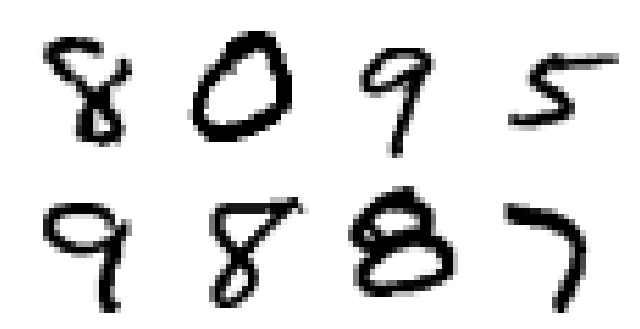

In [8]:
images, labels = next(iter(trainloader))
tools.show_images(images[:8], ncol=4, cmap='binary')

# Train a deep autoencoder

We train a deep autoencoders with only fully-connected layers.

## Encoder

Our encoder will have three hidden layers with ReLU nonlinearities. The exact architecture is not tested. We used the following architecture in our experiments:
- a fully-connected layer with 1000 units followed by ReLU nonlinearity
- a fully-connected layer with 500 units followed by ReLU nonlinearity
- a fully-connected layer with 250 units followed by ReLU nonlinearity
- a fully-connected layer with `n_components` outputs

In [9]:
class Encoder(nn.Module):
    def __init__(self, n_components):
        """
        Args:
          n_components (int): Number of elements in produced encodings.
        """
        # YOUR CODE HERE
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28,1000),  
            nn.ReLU(),
            nn.Linear(1000,500),  
            nn.ReLU(),
            nn.Linear(500, 250),
            nn.ReLU(),
            nn.Linear(250, n_components)
        )
#         raise NotImplementedError()

    def forward(self, x):
        """
        Args:
          x of shape (batch_size, n_channels=1, width, height): Examples to encode.

        Returns:
          z of shape (batch_size, n_components): Produced encodings.
        """
        # YOUR CODE HERE
        z = self.encoder(torch.flatten(x, start_dim=1))
        return z
        raise NotImplementedError()

In [10]:
def test_Encoder_shapes():
    n_components = 2
    encoder = Encoder(n_components)
    
    x = torch.randn(3, 1, 28, 28)
    y = encoder(x)
    assert y.shape == torch.Size([3, n_components]), f"Bad y.shape: {y.shape}"
    print('Success')

test_Encoder_shapes()

Success


## Decoder

Our decoder will have three hidden layers with ReLU nonlinearities. The exact architecture is not tested. We used the following architecture in our experiments:
- a fully-connected layer with 250 units followed by ReLU nonlinearity
- a fully-connected layer with 500 units followed by ReLU nonlinearity
- a fully-connected layer with 1000 units followed by ReLU nonlinearity
- a fully-connected layer with 784 outputs

In [11]:
class Decoder(nn.Module):
    def __init__(self, n_components):
        """
        Args:
          n_components (int): Number of elements in input codes.
        """
        # YOUR CODE HERE
        super(Decoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(n_components,250),  
            nn.ReLU(),
            nn.Linear(250,500),  
            nn.ReLU(),
            nn.Linear(500, 1000),
            nn.ReLU(),
            nn.Linear(1000, 784)
        )
#         raise NotImplementedError()

    def forward(self, z):
        """
        Args:
          z of shape (batch_size, n_components): Codes to decode.

        Returns:
          xrec of shape (batch_size, n_channels=1, width, height): Reconstructions computed from the given codes.
        """
        # YOUR CODE HERE
        batch_size = len(z)
        xrec = torch.reshape(self.encoder(z), (batch_size, 1, 28, 28))
        return xrec
        raise NotImplementedError()

In [12]:
def test_Decoder_shapes():
    n_components = 2
    decoder = Decoder(n_components)
    
    z = torch.randn(3, n_components)
    y = decoder(z)
    assert y.shape == torch.Size([3, 1, 28, 28]), "Bad shape of y: y.shape={}".format(y.shape)
    print('Success')

test_Decoder_shapes()

Success


# Train a bottleneck autoencoder

We will use the bottleneck autoencoder to encode MNIST images into 10-dimensional representations.

In [13]:
# Create a deep autoencoder
n_components = 10
encoder = Encoder(n_components)
encoder.to(device)

decoder = Decoder(n_components)
decoder.to(device)

Decoder(
  (encoder): Sequential(
    (0): Linear(in_features=10, out_features=250, bias=True)
    (1): ReLU()
    (2): Linear(in_features=250, out_features=500, bias=True)
    (3): ReLU()
    (4): Linear(in_features=500, out_features=1000, bias=True)
    (5): ReLU()
    (6): Linear(in_features=1000, out_features=784, bias=True)
  )
)

### Training loop

Implement the training loop in the cell below. In the training loop, the training data are first encoded into lower-dimensional representations using the encoder. Then, the decoder is used to produce the reconstructions of the original images from the lower-dimensional code. We will use the `MSELoss` to measure the reconstruction error, which is minimized during training.

The recommended hyperparameters:
* Adam optimizer with learning rate 0.001

Hints:
- Training usually converges fast, four epochs is usually enough.
- The loss at convergence should be close to 0.066.

In [14]:
parameters = list(encoder.parameters()) + list(decoder.parameters())
optimizer = torch.optim.Adam(parameters, lr=0.001)
criterion = nn.MSELoss()
n_epochs = 4
# Training loop
if not skip_training:
    # YOUR CODE HERE
    for epoch in range(n_epochs): 
        for images, labels_ in trainloader:
            optimizer.zero_grad()
            
            encoder_output = encoder.forward(images)
            decoder_output = decoder.forward(encoder_output)

            loss = criterion(decoder_output, images)
            loss.backward()

            optimizer.step()

        print("Epochs:",epoch, "Loss:", loss.item())
    print("Trainning done")
#     raise NotImplementedError()

In [15]:
# Save the model to disk (the pth-files will be submitted automatically together with your notebook)
# Set confirm=False if you do not want to be asked for confirmation before saving.
if not skip_training:
    tools.save_model(encoder, '1_ae_encoder.pth', confirm=True)
    tools.save_model(decoder, '1_ae_decoder.pth', confirm=True)

In [16]:
if skip_training:
    encoder = Encoder(n_components=10)
    tools.load_model(encoder, '1_ae_encoder.pth', device)

    decoder = Decoder(n_components=10)
    tools.load_model(decoder, '1_ae_decoder.pth', device)

Model loaded from 1_ae_encoder.pth.
Model loaded from 1_ae_decoder.pth.


### Visualize embeddings

Let us visualize the latent space in the cell below. If your autoencoder does a good job, you should clearly see ten clusters corresponding to the ten classes.

Use t-SNE


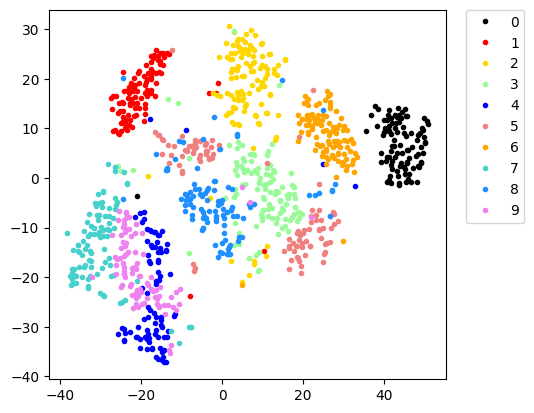

In [17]:
tests.visualize_embeddings(encoder, trainloader, n_samples=1000, device=device)

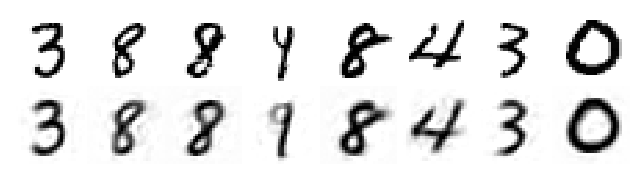

In [18]:
# Let's visualize test images and their reconstructions using the trained autoencoder
tests.visualize_reconstructions(encoder, decoder, trainloader, device=device)

## Test the quality of the produced embeddings by classification

We will test the quality of the produced encodings by training a classifier using the encoded images.

In [19]:
testset = torchvision.datasets.MNIST(root=data_dir, train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False)

In [20]:
# Encode data samples using the encoder
@torch.no_grad()
def encode(dataset, encoder):
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=100, shuffle=False)

    embeddings = []
    labels = []
    for images, labels_ in dataloader:
        embeddings.append(encoder(images.to(device)))
        labels.append(labels_)

    embeddings = torch.cat(embeddings, dim=0)
    labels = torch.cat(labels, dim=0)
    return embeddings, labels

In [21]:
# Save and submit the AE embeddings
if not skip_training:
    traincodes, trainlabels = encode(trainset, encoder)  # traincodes is (60000, 10)
    testcodes, testlabels = encode(testset, encoder)  # testcodes is (10000, 10)
    torch.save([traincodes, trainlabels, testcodes, testlabels], '1_ae_embeddings.pth')
else:
    traincodes, trainlabels, testcodes, testlabels = torch.load('1_ae_embeddings.pth', map_location=lambda storage, loc: storage)

In [22]:
# Train a simple linear classifier
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(C=1e5, solver='lbfgs', multi_class='multinomial')
logreg.fit(traincodes.cpu(), trainlabels.cpu())

predicted_labels = logreg.predict(testcodes.cpu())  # (10000,)

accuracy = np.sum(testlabels.cpu().numpy() == predicted_labels) / predicted_labels.size
print('Accuracy with a linear classifier: %.2f%%' % (accuracy*100))
assert accuracy > .85, "Poor accuracy of the embeddings: classification accuracy is %.2f%%" % (accuracy*100)
print('Success')

Accuracy with a linear classifier: 90.24%
Success


<div class="alert alert-block alert-info">
<b>Conclusion</b>
</div>

In this exercise, we reduced the dimensionality of the MNIST data from $28 \times 28 = 784$ to $10$ using a bottleneck autoecoder. Using a very simple linear classifier, we were able to classify the encoded images with a good accuracy, which is the evidence that the structure of the data is well preserved in the embedding space.